<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-09-19' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20153015" #@param {type:"string"}
Student_full_name = "Mark Garvey" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = Final #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

plt.rcParams['figure.figsize'] = [12, 8]

In [6]:
# Setting a seed:
np.random.seed(123)

## Dataset

### Loading the MNIST dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Path, copy the path from your Drive
Path = '/content/drive/MyDrive/Code/Assignments/'

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


## Normalise data, to be within range of 0-1:

In [9]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [10]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of mnist image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

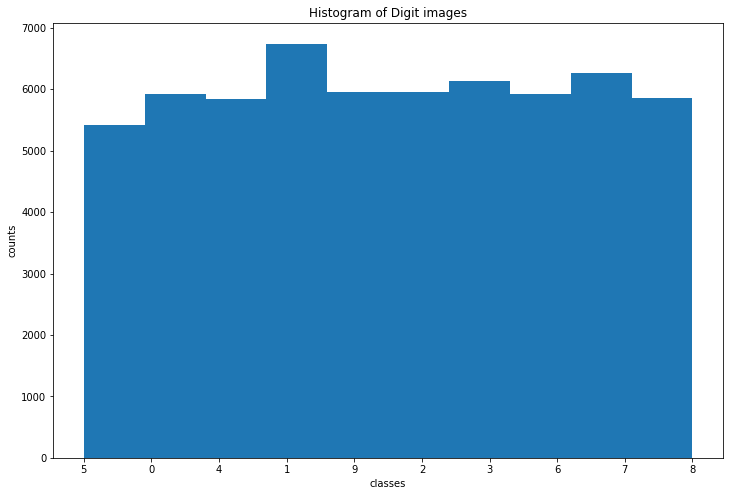

In [11]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist([str(i) for i in y_train], n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

Classes appear to be evenly distributed overall, with slightly more samples for class 1, 3 and 7.

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [12]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
classes

[1, 2, 6]

In [13]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 1000
inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

In [14]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

New Classes Distribution

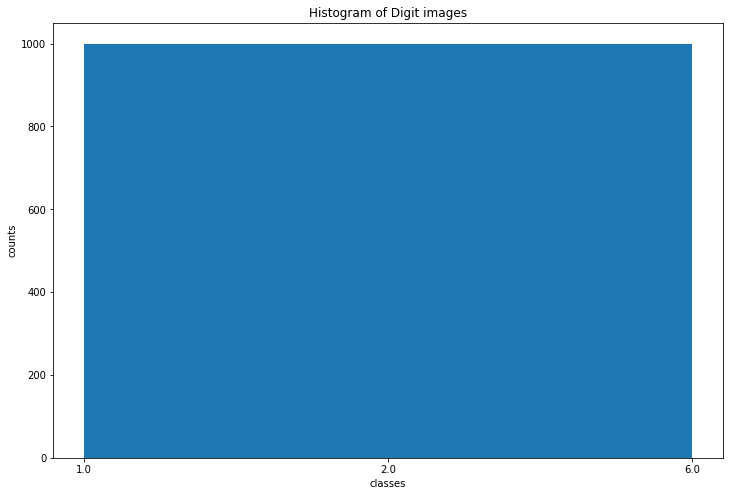

In [15]:
# new histogram
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist([str(i) for i in y_train], n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

We have selected 1000 random samples for each of our chosen classes: 2, 7 and 8.

In [16]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Selected Indices:
[ 276  768  204  335  841  849  170  259  300 1226 1341 1107 1045 1220
 1810 1885 1634 1179 2032 2932 2588 2695 2168 2725 2650 2820 2575]


Text(0.5, 1.0, 'Original')

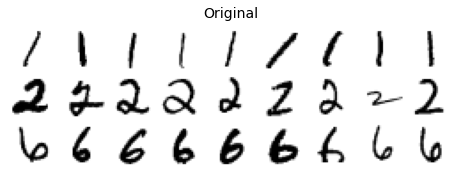

In [17]:


# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:
label_indices = np.hstack([np.random.choice(np.where(y_train==label)[0], size=9) for label in classes])

print('Selected Indices:')
print(label_indices)

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=9)
plt.title("Original", fontsize=14)



###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [18]:
### Split the dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [19]:
# print shape of your validation and training set
print(X_val.shape)
print(X_train.shape)



(600, 784)
(2400, 784)


### General-Recipe ML

In [21]:
# model
model_log = LogisticRegression(multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)


print(classification_report(y_val, y_pred_log))
              
# Computing the Accuracy:
print('Accuracy is:')
print(accuracy_score(y_pred_log, y_val))
print('')
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_pred_log, y_val))

              precision    recall  f1-score   support

         1.0       0.97      0.98      0.98       237
         2.0       0.94      0.98      0.96       187
         6.0       0.99      0.94      0.97       176

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Accuracy is:
0.9683333333333334

[[232   2   4]
 [  5 183   6]
 [  0   2 166]]


The general recipe Logistic Regression is 96% accurate when predicting across the 3 classes. 

The confusion matrix shows the **most false positive predictions** belong to the third class, **class 6**. 


*   There are 4 instances where class 6 was falsely  predicted to be class 1.
*   There are 6 instances where class 6 was falsely  predicted to be class 2.

This results in class 6 having the lowest recall score among the three classes, as observed in the classification report above.

This means it correctly predicts 94% of all the class 6 predictions made. Comparitavely, class 0 and 1 have higher recall of 98%.

One could say that class 6 is the class where there is the most uncertainty about whether a prediction of this class is true or not.



In [22]:
prob_classmax = np.max(y_pred_logi_prob,axis=1)
prob_classmax[y_pred_logi_prob!=y_val]

array([[0.99262366, 0.9642093 , 1.        , 0.9996684 , 0.99866365,
        0.99999865, 0.99996613, 0.99627521, 0.99993955, 0.99944142,
        0.98939665, 0.99109288, 0.99914662, 0.99451793, 0.8951549 ,
        0.99999786, 0.99999822, 0.98228139, 0.97849008, 0.99110461,
        0.99990202, 0.99875315, 0.99994812, 0.99998452, 0.99997709,
        0.99360666, 0.99602481, 0.99756929, 0.99999988, 0.9991082 ,
        0.99967199, 0.997259  , 0.99739428, 0.99999678, 0.99998554,
        0.99985035, 0.99972334, 0.99996052, 0.99980843, 0.99997368,
        0.99999923, 0.99303287, 0.9991659 , 0.99069398, 0.99677686,
        0.99076498, 0.57001451, 0.9999999 , 0.97440735, 0.99915391,
        0.99988913, 0.96315567, 0.99918325, 0.99464488, 0.99997597,
        0.99257257, 0.99992698, 0.99777591, 0.98509472, 0.99787257,
        0.99995751, 0.75551076, 0.7496085 , 0.99185086, 0.99992227,
        0.99942553, 0.99828187, 0.99805041, 0.99981144, 0.99720282,
        0.99964026, 0.99948118, 0.99994776, 0.99

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [23]:
import sklearn.preprocessing
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
nf = X_train.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

In [24]:
y_2_bin


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

Train Bayesian LR model using [ADVI](https://arxiv.org/abs/1603.00788):

In [25]:

with multi_logistic:
    approx = pm.fit(300000, method='advi') # takes longer
    #approx = pm.fit(3000, method='advi')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 3,265.4


Plot loss for Bayesian multinomial logistic regression:

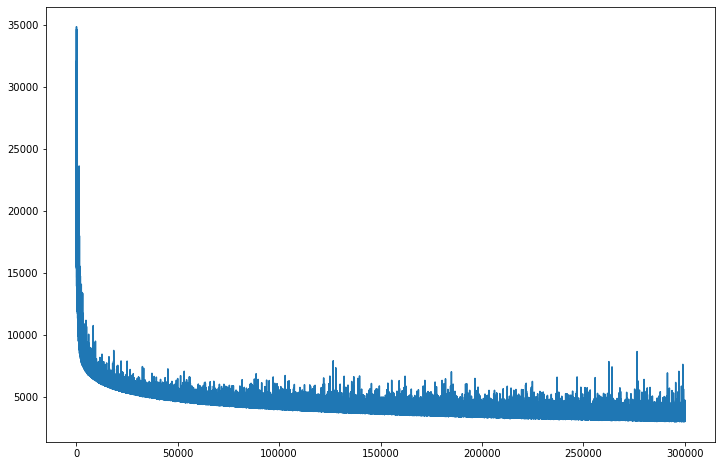

In [26]:
plt.plot(approx.hist)

In [27]:
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 2.0
classes: [1, 2, 6]
estimated prob= [0. 1. 0.]


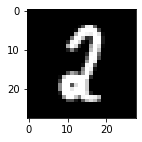

In [45]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

We see above that for this sample, the model was 100% confident that the image belonged to class 2, and was correct in this prediction.

In [46]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [47]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([1, 2, 2, 6, 6, 6, 6, 1, 2, 6])

In [48]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9716666666666667


## Selecting different instances


In [33]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [34]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.99990695, 0.        ],
       [1.        , 0.9223937 , 0.26068286],
       [1.        , 1.        , 0.        ],
       [2.        , 1.        , 0.        ],
       [2.        , 1.        , 0.        ],
       [2.        , 1.        , 0.        ],
       [2.        , 1.        , 0.        ],
       [0.        , 0.99990188, 0.        ],
       [1.        , 1.        , 0.        ],
       [2.        , 1.        , 0.        ]])

In [35]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[0.        , 0.52203459, 0.49982219],
       [2.        , 0.52761646, 0.49959984],
       [1.        , 0.5267833 , 0.49945526],
       [0.        , 0.55625735, 0.49749372],
       [2.        , 0.5699428 , 0.49553562],
       [1.        , 0.58501134, 0.49300665],
       [0.        , 0.59306787, 0.49121165],
       [1.        , 0.59397563, 0.48989795],
       [2.        , 0.59921545, 0.48848974],
       [1.        , 0.60553885, 0.48774994]])

In [36]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi_prob != y_val]

array([[0.99262366, 0.9642093 , 1.        , 0.9996684 , 0.99866365,
        0.99999865, 0.99996613, 0.99627521, 0.99993955, 0.99944142,
        0.98939665, 0.99109288, 0.99914662, 0.99451793, 0.8951549 ,
        0.99999786, 0.99999822, 0.98228139, 0.97849008, 0.99110461,
        0.99990202, 0.99875315, 0.99994812, 0.99998452, 0.99997709,
        0.99360666, 0.99602481, 0.99756929, 0.99999988, 0.9991082 ,
        0.99967199, 0.997259  , 0.99739428, 0.99999678, 0.99998554,
        0.99985035, 0.99972334, 0.99996052, 0.99980843, 0.99997368,
        0.99999923, 0.99303287, 0.9991659 , 0.99069398, 0.99677686,
        0.99076498, 0.57001451, 0.9999999 , 0.97440735, 0.99915391,
        0.99988913, 0.96315567, 0.99918325, 0.99464488, 0.99997597,
        0.99257257, 0.99992698, 0.99777591, 0.98509472, 0.99787257,
        0.99995751, 0.75551076, 0.7496085 , 0.99185086, 0.99992227,
        0.99942553, 0.99828187, 0.99805041, 0.99981144, 0.99720282,
        0.99964026, 0.99948118, 0.99994776, 0.99

In [37]:
y_predB[y_pred_logi_prob != y_val,:]

array([[[0.        , 0.99990695, 0.        ],
        [1.        , 0.9223937 , 0.26068286],
        [1.        , 1.        , 0.        ],
        ...,
        [0.        , 0.99876698, 0.        ],
        [0.        , 0.99998018, 0.        ],
        [2.        , 1.        , 0.        ]]])

In [38]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.84


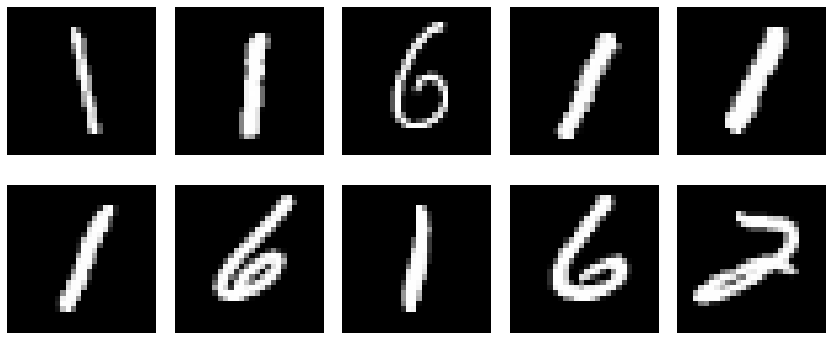

In [39]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

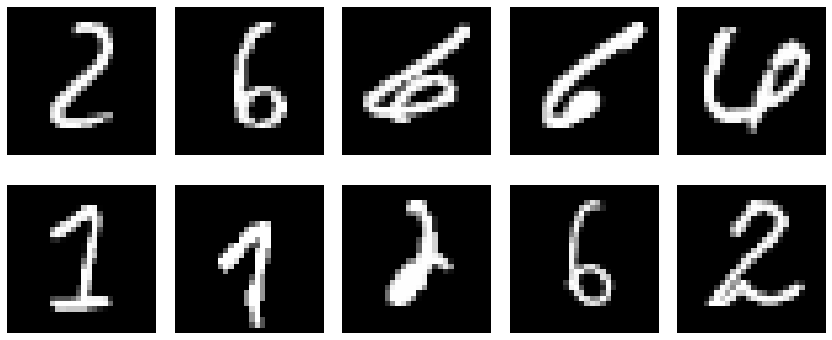

In [40]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

* Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.
* Compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

In [93]:
# only save easy data with predictions (exclude those with a high standard deviation): 
X_test_easy_only = X_val[y_predB[:,2] < 0.1]
y_test_easy_only = y_val[y_predB[:,2] < 0.1]

In [99]:
# General recipe model for X_test_easy_only, with difficult samples removed:

y_pred_log = model_log.predict(X_test_easy_only)
y_pred_logi_prob = model_log.predict_proba(X_test_easy_only)

print("Original test dataset: ", len(X_val))
print("Number of difficult instances removed with standard dev. over 0.1: ", len(X_val) - len(X_test_easy_only))
print("Number of remaining non-difficult instances: ", len(X_test_easy_only))
print("")


print(classification_report(y_pred_log, y_test_easy_only))
print("Accuracy of general recipe LR model after removing difficult instances: ") 
print(accuracy_score(y_pred_log, y_test_easy_only))
print("")
print(confusion_matrix(y_pred_log, y_test_easy_only))

Original test dataset:  600
Number of difficult instances removed with standard dev. over 0.1:  99
Number of remaining non-difficult instances:  501

              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00       200
         2.0       1.00      0.98      0.99       150
         6.0       0.99      1.00      1.00       151

    accuracy                           0.99       501
   macro avg       0.99      0.99      0.99       501
weighted avg       0.99      0.99      0.99       501

Accuracy of general recipe LR model after removing difficult instances: 
0.9940119760479041

[[200   0   0]
 [  2 147   1]
 [  0   0 151]]


We see improved precision and recall across the 3 classes, when the difficult instances are removed.

## Summary

* 3 classes were randomly subsetted from the 10-class dataset. A training set of 2400 and a test set of 600 was randomly sampled across these three classes. 
* An initial logistic regression model was fit to this data. The accuracy across the test data of 600 instances was 96%.
* A Bayesian multinomial logistic regression classifier was trained, and improved classsification accuracy to 97%. Additionally, using a Bayesian method to assess data samples shows us the probability distributions for a test sample being predicted a certain class. 
* Using these probabilities, we can exclude difficult to classify samples, or where there is a high standard deviation (and therefore lower prediction probability confidence.)
* Finally, with the difficult to classify samples excluded from the test dataset, the original logistic regression classifier was again used to predict on the new smaller test set of "easy" samples.
* The accuracy now improved to 99%, with less false positives and improved recall overall, as observed by the classification report.





#### References:


[Kucukelbir, A., Tran, D., Ranganath, R., Gelman, A., & Blei, D. M. (2017). Automatic differentiation variational inference. The Journal of Machine Learning Research, 18(1), 430-474.](https://arxiv.org/abs/1603.00788)

 Kana, M.(2020). Introduction to Bayesian Logistic Regression, [Towards Data Science](https://towardsdatascience.com/introduction-to-bayesian-logistic-regression-7e39a0bae691)  - Good primer on inner workings of Bayesian LR
